In [1]:
import sys
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Dataset

In [3]:
classes_labels = [
    "hand clap",
    "right hand wave",
    "left hand wave",
    "right arm clockwise",
    "right arm counterclockwise",
    "left arm clockwise",
    "left arm counterclockwise",
    "arm roll",
    "air drums",
    "air guitar",
    "other gestures",
]

right arm counterclockwise


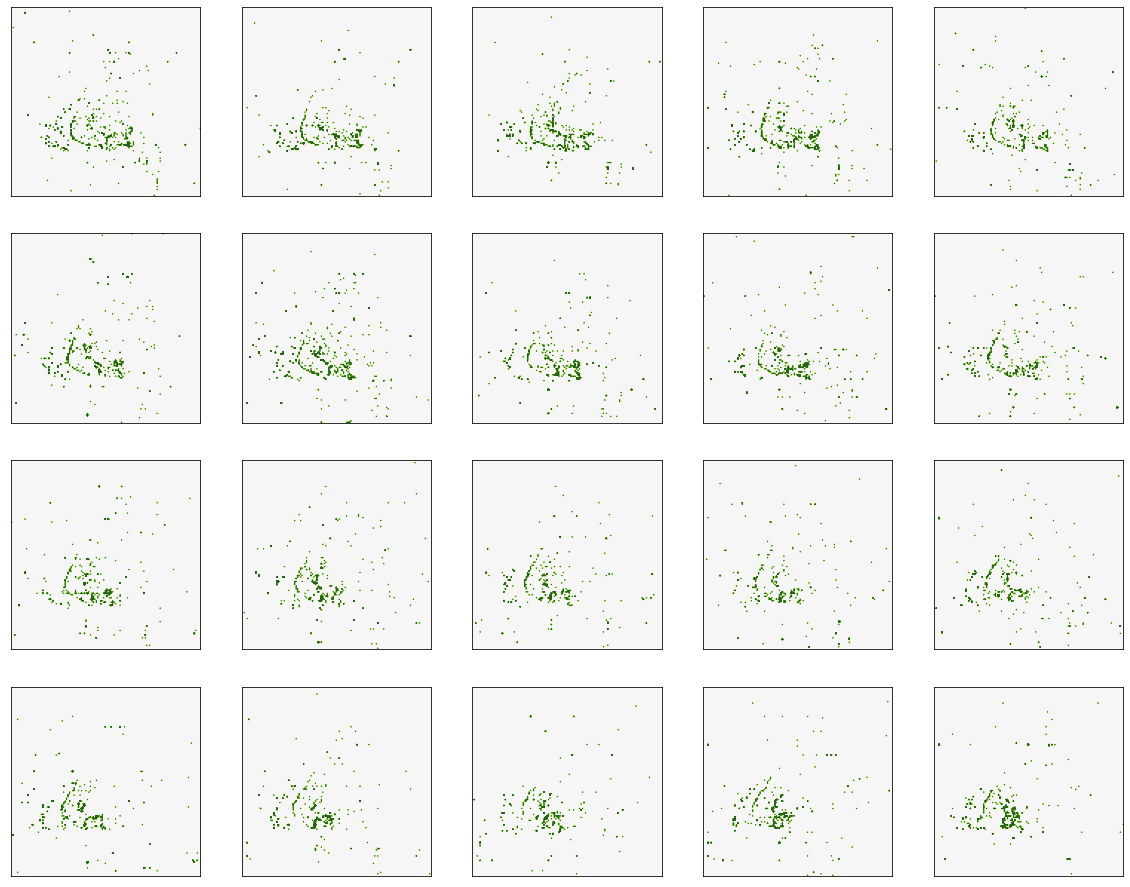

In [4]:
from dataloader_IBMGestures import IBMGesturesDataLoader

dt = 10000
dataloader = IBMGesturesDataLoader().get_data_loader("test", num_workers=1, batch_size=1, dt=dt)

for img, label in dataloader:
    print(classes_labels[label.item()])
    img = img[0]  # remove singleton batch dimension
    plt.figure(figsize=(20, 16))
    for i, frame in enumerate(img.squeeze()): # over time steps
        plt.subplot(4, 5, i+1)
        frame = frame.sum(0)  # remove channel dimension
        plt.imshow(frame, vmin=-1, vmax=1, cmap=plt.cm.PiYG)
        plt.xticks([])
        plt.yticks([])
    break

# Network definition

In [5]:
from networks import load_gestures_snn

snn = load_gestures_snn("../data/Gestures/pretrain.model")

In [6]:
from sparsefool import sparsefool
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_HAMMING_DISTANCE = 1000
LAMBDA = 4.
# # stochastic rounding:
# round_fn = lambda x: (torch.rand(size=x.shape, device=device) < x).float()

bin_img = torch.clamp(img, 0, 1).to(device)

return_dict_sparse_fool = sparsefool(
    x_0=bin_img,
    net=snn,
    max_hamming_distance=MAX_HAMMING_DISTANCE,
    lambda_=LAMBDA,
    epsilon=0.0,
    overshoot=0.02,
    device=device,
    early_stopping=True,
    boost=False,
    verbose=False,
)

print("L0", return_dict_sparse_fool["L0"])
print("Predicted", return_dict_sparse_fool["predicted"])
print("Predicted after attack", return_dict_sparse_fool["predicted_attacked"])
print("N. Queries", return_dict_sparse_fool["n_queries"])
print("Elapsed time", return_dict_sparse_fool["elapsed_time"])

L0 110
Predicted 4
Predicted after attack 3
N. Queries 7
Elapsed time 2.431546926498413


Text(0.5, 0.98, 'Original prediction: right arm counterclockwise;  After attack: right arm clockwise')

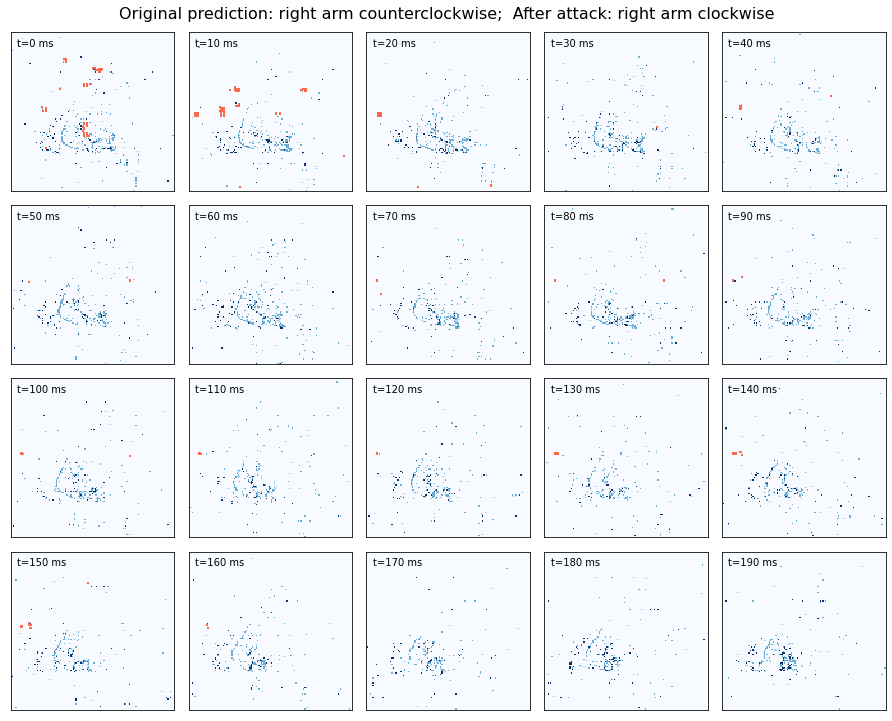

In [7]:
from numpy import ma

X_adv = return_dict_sparse_fool["X_adv"].cpu().squeeze().numpy()
X_orig = bin_img.cpu().squeeze().numpy()
X_diff = X_adv - X_orig


plt.figure(figsize=(5*2.5, 4.2*2.5))
for i in range(len(X_adv)): # over time steps
    plt.subplot(4, 5, i+1)
    
    fr_orig = X_orig[i].sum(0)[::-1]
    fr_diff = X_diff[i].sum(0)[::-1]
#     fr_orig = ma.masked_array(fr_orig, fr_orig==0)
    fr_diff = ma.masked_array(fr_diff, fr_diff==0)
    
    plt.pcolormesh(fr_orig, vmin=0, vmax=2, cmap=plt.cm.Blues)
    plt.pcolormesh(fr_diff, vmin=0, vmax=2, cmap=plt.cm.Reds)
    plt.text(5,117,f"t={i*dt//1000} ms")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle(f"Original prediction: {classes_labels[return_dict_sparse_fool['predicted']]};"
             f"  After attack: {classes_labels[return_dict_sparse_fool['predicted_attacked']]}",
            size=16)
